# Тренировка нейросети 2-го этапа по детекции пиктограмм на yandex smartcaptcha

**Описание:**

Обучаемая нейросеть должна детектировать пиктограммы на сложном фоне из верхней части капчи. 15 классов.

In [ ]:
import torch
import torchvision
import numpy as np
import pandas as pd
import os
import cv2
import time
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.ops.boxes import nms
from google.colab import drive
from torchvision.transforms import functional as F
from torchvision.models.detection.rpn import AnchorGenerator
drive.mount ('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!git clone https://github.com/Krilaria/Finger_Net.git

Cloning into 'Finger_Net'...
remote: Enumerating objects: 686, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 686 (delta 1), reused 0 (delta 0), pack-reused 642
Receiving objects: 100% (686/686), 101.60 MiB | 1.33 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [ ]:
df_train = pd.read_csv("/content/Finger_Net/Train_15_530.csv",
                       names=['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'class'])
df_val = pd.read_csv('/content/Finger_Net/Val_15_553.csv',
                    names=['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'class'])

In [ ]:
class_mapping = {
    'bucket': 1,
    'clock': 2,
    'face': 3,
    'factory': 4,
    'fire': 5,
    'flag': 6,
    'hand': 7,
    'key': 8,
    'lock': 9,
    'monitor': 10,
    'paper': 11,
    'person': 12,
    'scissors': 13,
    't-shirt': 14,
    'wrench': 15
}

df_train['bbox'] = df_train[['xmin', 'ymin', 'xmax', 'ymax']].apply(list, axis=1)
df_val['bbox'] = df_val[['xmin', 'ymin', 'xmax', 'ymax']].apply(list, axis=1)

df_train['class'] = df_train['class'].map(class_mapping)
df_val['class'] = df_val['class'].map(class_mapping)

df_train = df_train.drop(columns=['xmin', 'ymin', 'xmax', 'ymax']).groupby('filename', as_index=False).agg(list)
df_val = df_val.drop(columns=['xmin', 'ymin', 'xmax', 'ymax']).groupby('filename', as_index=False).agg(list)

In [ ]:
print(f'Число изображений в тренировочной выборке: {df_train["filename"].nunique()}')
print(f'Число изображений в валидационной выборке: {df_val["filename"].nunique()}')

df_train.head()

Число изображений в тренировочной выборке: 530
Число изображений в валидационной выборке: 23


,filename,class,bbox
0,0001.jpg,"[15, 3]","[[731, 486, 986, 766], [1064, 423, 1265, 614]]"
1,0002.jpg,"[4, 5]","[[785, 130, 1105, 429], [226, 269, 573, 573]]"
2,0003.jpg,"[6, 5]","[[478, 622, 744, 806], [1064, 122, 1393, 404]]"
3,0004.jpg,[5],"[[348, 106, 617, 380]]"
4,0005.jpg,"[14, 10, 15]","[[71, 567, 285, 785], [76, 149, 296, 345], [96..."


In [ ]:
class MyDataset(Dataset):

    def __init__(self, dataframe, img_path):

        self.df = dataframe
        self.img_path = img_path

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        img_name = self.df.loc[index,'filename']
        boxes = torch.Tensor(self.df.loc[index, 'bbox']).to(torch.float)
        labels = torch.Tensor(self.df.loc[index, 'class']).to(torch.int64)
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 0])
        iscrowd = torch.zeros(labels.shape[0], dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        img = cv2.imread(os.path.join(self.img_path, img_name))/255.
        img = torch.from_numpy(img).permute(2, 0, 1).to(torch.float)
        return img, target

In [ ]:
def create_model(num_classes, pretrained=False):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
batch_size = 5     #  2 - 2.7 min/epoch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model(num_classes=15+1, pretrained=False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

train_dataset = MyDataset(df_train, '/content/Finger_Net/Dataset_15')
val_dataset = MyDataset(df_val, '/content/Finger_Net/Dataset_15')

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 269MB/s]


In [ ]:
def train(train_dataloader):
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"\tИтерация #{i} loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader):
    running_loss = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss

In [ ]:
num_epoch = 25

train_losses = []
val_losses = []
try:
    start1 = time.time()
    for epoch in range(num_epoch):
        start = time.time()
        train_loss = train(train_data_loader)
        val_loss = val(val_data_loader)
        scheduler.step()
        print(f"Эпоха #{epoch+1} train_loss: {train_loss}, val_loss: {val_loss}")
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch+1}-ю эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    endend = time.time()
    print(f"Всего потрачено {round((endend - start1) / 60, 1)} минут")
except KeyboardInterrupt:
    print('Прервано пользователем')

	Итерация #0 loss: 3.562302589416504
	Итерация #50 loss: 0.6377229690551758
	Итерация #100 loss: 0.9368453621864319
Эпоха #1 train_loss: 0.1499957672829898, val_loss: 0.1750374462293542
Потрачено 2.8 минут на 1-ю эпоху
	Итерация #0 loss: 0.6236456632614136
	Итерация #50 loss: 0.8021431565284729
	Итерация #100 loss: 0.3417634963989258
Эпоха #2 train_loss: 0.11570162936201635, val_loss: 0.13579232796378757
Потрачено 2.7 минут на 2-ю эпоху
	Итерация #0 loss: 0.590298056602478
	Итерация #50 loss: 0.7449497580528259
	Итерация #100 loss: 0.5908328890800476
Эпоха #3 train_loss: 0.1132995511001011, val_loss: 0.10566050980402075
Потрачено 2.7 минут на 3-ю эпоху
	Итерация #0 loss: 0.3267362117767334
	Итерация #50 loss: 0.6190252900123596
	Итерация #100 loss: 0.6776553392410278
Эпоха #4 train_loss: 0.09440495759811042, val_loss: 0.09590530136357182
Потрачено 2.7 минут на 4-ю эпоху
	Итерация #0 loss: 0.37825873494148254
	Итерация #50 loss: 0.41884976625442505
	Итерация #100 loss: 0.427117943763732

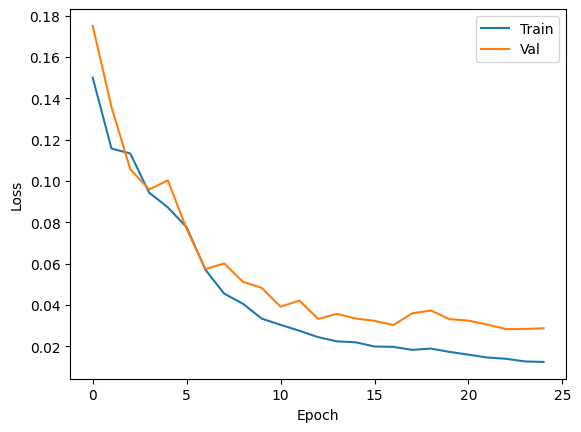

In [ ]:
fig, ax  = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(val_losses, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()

In [ ]:
def draw_predict(df_index, iou_threshold=0.1, threshold=0.8, scale_percent=60): # 0.1  порог IoU для NMS    0.8 порог для отбора предсказаний
    model.eval() # режим оценки
    img = cv2.imread(os.path.join('/content/Finger_Net/Dataset_15', df_val.loc[df_index, 'filename'])) # загрузка картинки (указание пути)
    img_ = img / 255. # normalization
    img_ = torch.from_numpy(img_).permute(2, 0, 1).unsqueeze(0).to(torch.float).to(device) # img to tensor, изменяется размерность и приводится к float
    predict = model(img_) # получение предсказаний
    ind = nms(predict[0]['boxes'], predict[0]['scores'], iou_threshold).detach().cpu().numpy() #
    for i, box in enumerate(predict[0]['boxes'][ind]): #
        if predict[0]['scores'][i] > threshold: #++
            cv2.rectangle(img,
                    (int(box[0]), int(box[1])),
                    (int(box[2]), int(box[3])),
                    (255, 0, 0), 8)
            cv2.circle(img,(int(((box[0])+(box[2]))/2),int(((box[1])+(box[3]))/2)), 20,(0,255,0), -1)
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    img = cv2.resize(img, dim)
    return img

In [ ]:
def draw_predict_2(df_index, iou_threshold=0.1, threshold=0.4, scale_percent=40):
    model.eval()
    img = cv2.imread(os.path.join('/content/Finger_Net/Dataset_15', df_val.loc[df_index, 'filename']))
    img_ = img / 255.
    img_ = torch.from_numpy(img_).permute(2, 0, 1).unsqueeze(0).to(torch.float).to(device)
    predict = model(img_)
    ind = nms(predict[0]['boxes'], predict[0]['scores'], iou_threshold).detach().cpu().numpy()

    class_names = ["", "bucket", "clock", "face", "factory", "fire", "flag", "hand", "key", "lock",
                   "monitor", "paper", "person", "scissors", "t-shirt", "wrench"]

    for i, box in enumerate(predict[0]['boxes'][ind]):
        if predict[0]['scores'][i] > threshold:
            class_idx = int(predict[0]['labels'][i])
            class_name = class_names[class_idx]

            cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 8)
            cv2.circle(img, (int((box[0] + box[2]) / 2), int((box[1] + box[3]) / 2)), 20, (0, 255, 0), -1)
            cv2.putText(img, class_name, (int(box[0]), int(box[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    img = cv2.resize(img, dim)
    return img

In [ ]:
# Создание списка порогов
thresholds = [0.05, 0.25, 0.4, 0.6, 0.8, 0.95]

# Количество изображений в валидационной выборке
num_images = len(df_val)

# Создание графика
fig, axs = plt.subplots(num_images, len(thresholds), figsize=(12, 1.2*num_images))

# Цикл по изображениям и порогам
for i in range(num_images):
    for j in range(len(thresholds)):
        ax = axs[i, j]
        ax.axis('off')
        img = draw_predict_2(i, iou_threshold=0.1, threshold=thresholds[j])
        ax.imshow(img)
        if i == 0:
            ax.set_title(f'Threshold: {thresholds[j]:.2f}')

plt.tight_layout()
plt.show()

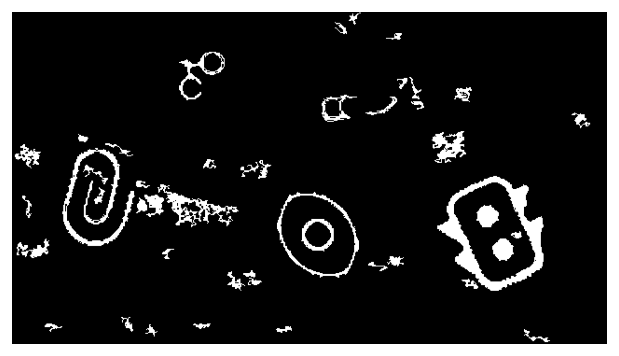

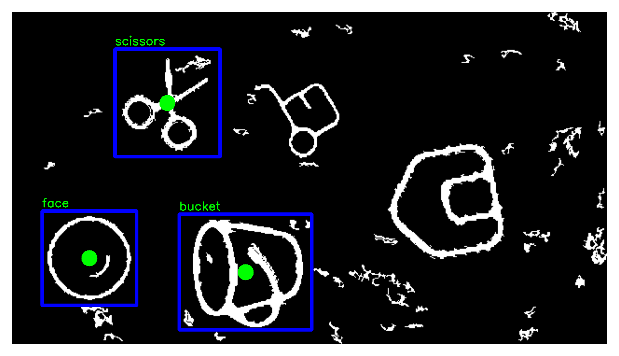

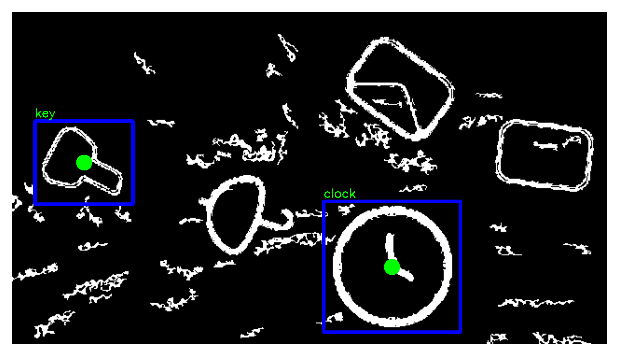

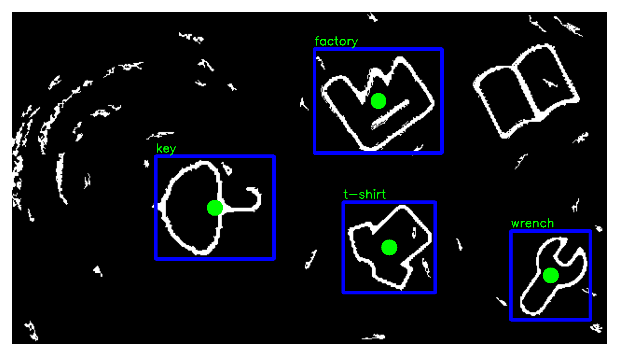

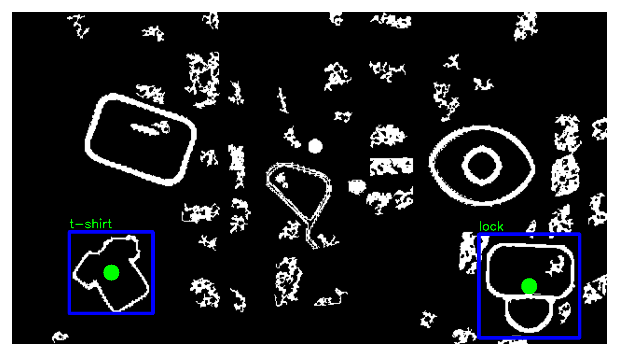

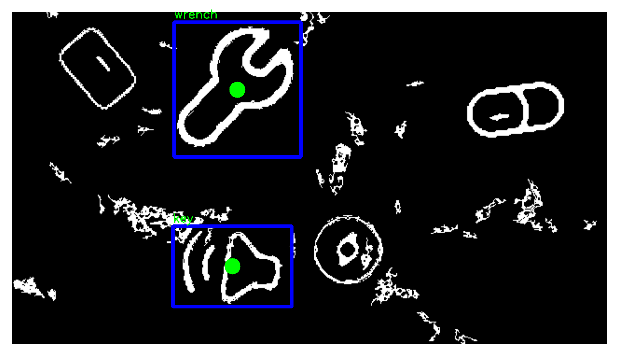

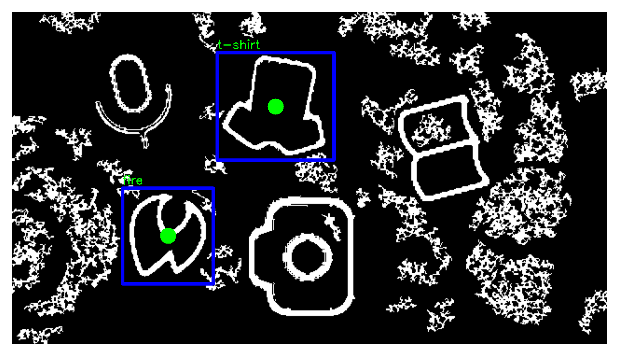

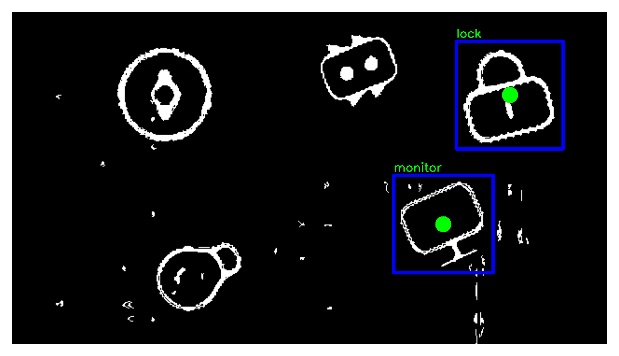

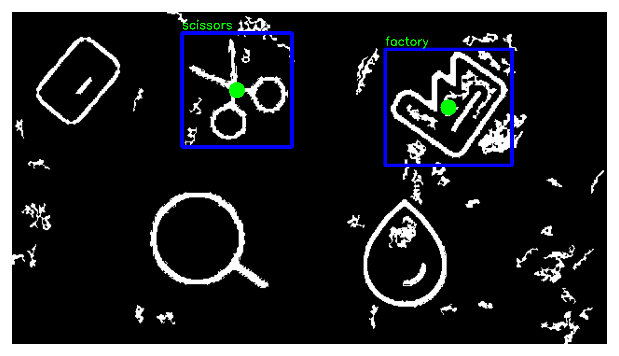

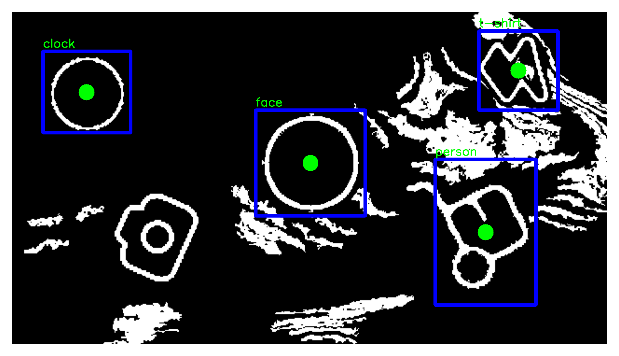

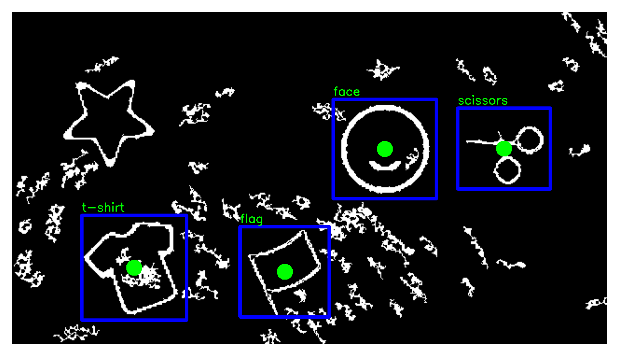

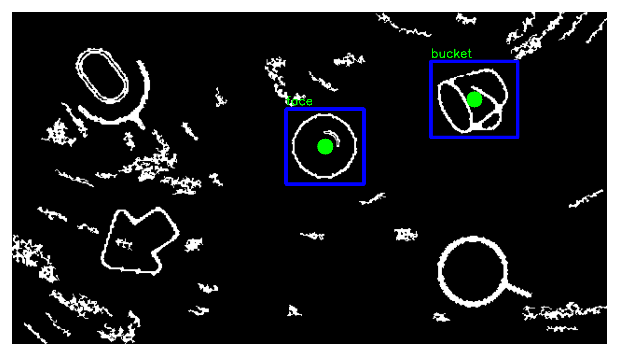

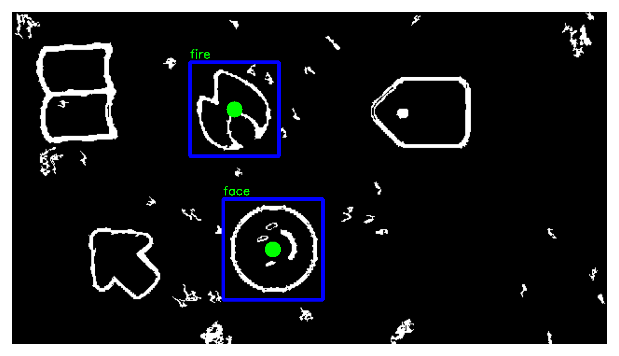

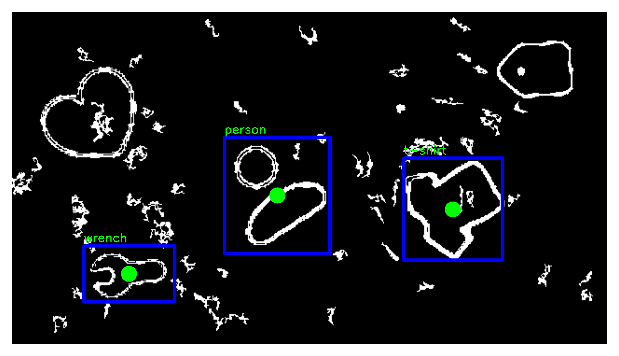

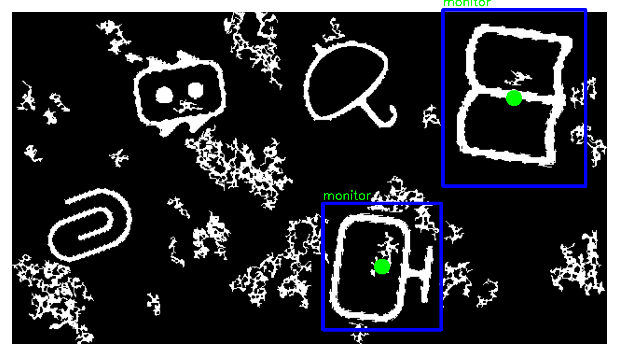

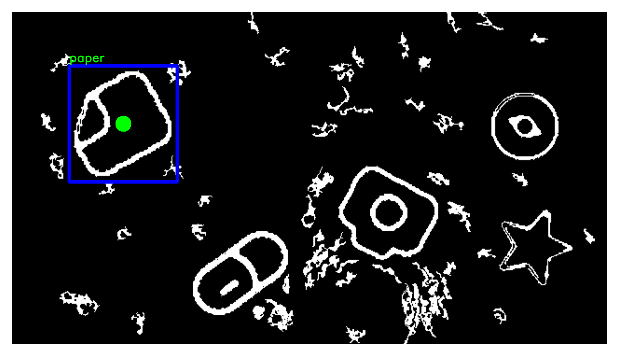

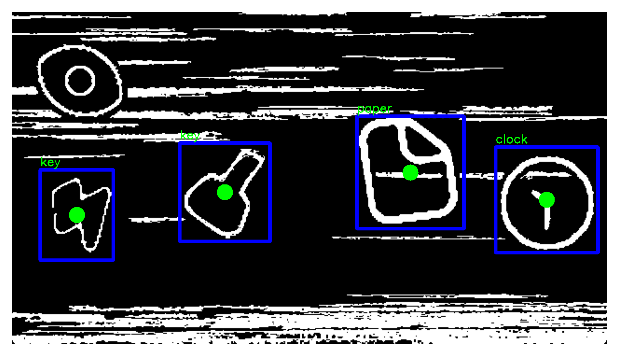

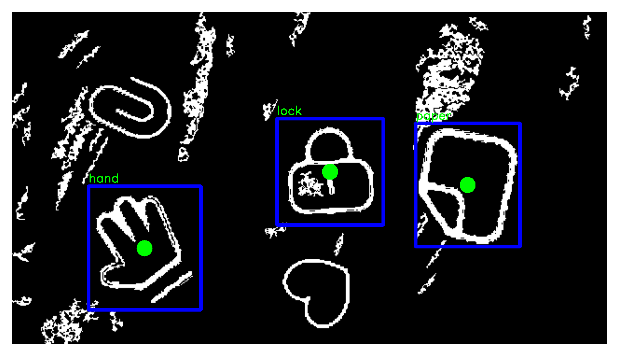

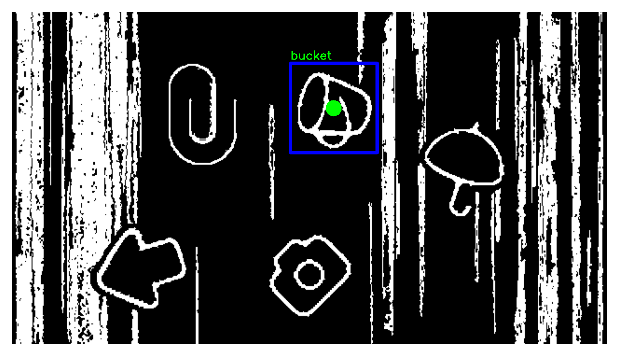

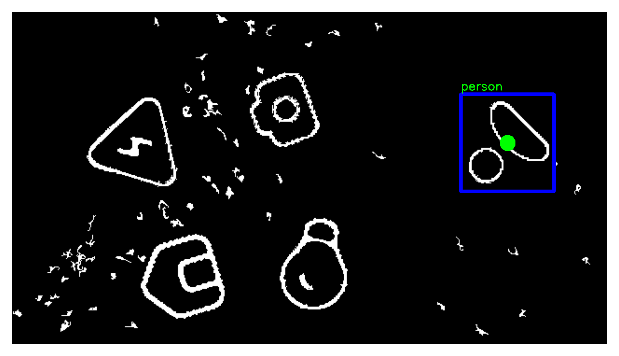

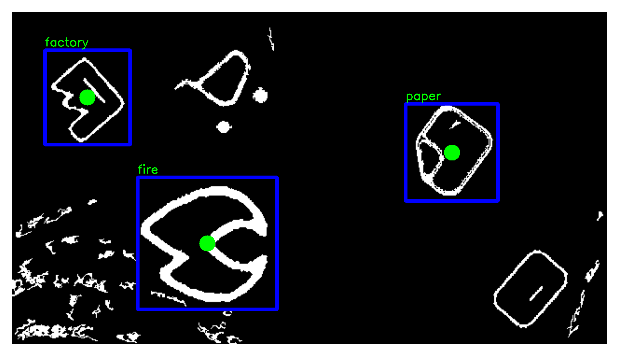

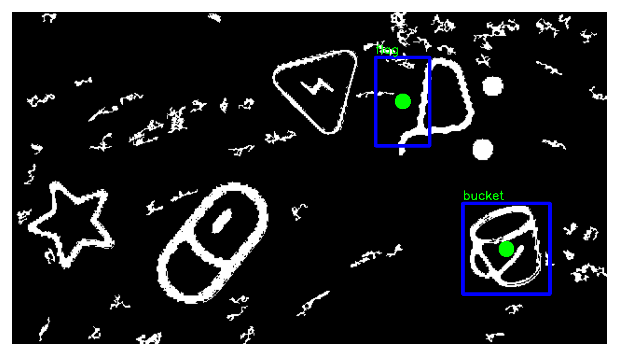

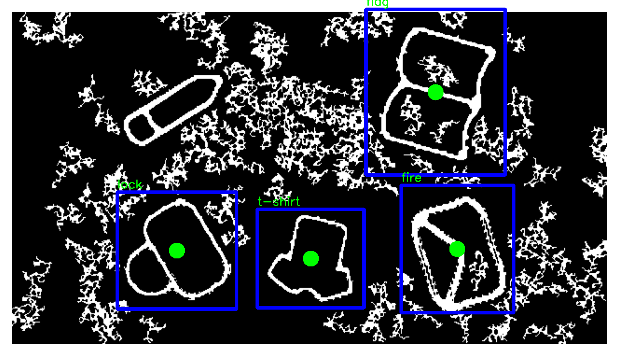

In [ ]:
for i in range(num_images):
    cv2_imshow(draw_predict_2(i))

In [ ]:
def draw_predict_3(df_index, iou_threshold=0.1, threshold=0.4):
    model.eval()
    img = cv2.imread(os.path.join('/content/Finger_Net/Dataset_15', df_val.loc[df_index, 'filename']))
    img_ = img / 255.
    img_ = torch.from_numpy(img_).permute(2, 0, 1).unsqueeze(0).to(torch.float).to(device)
    predict = model(img_)
    ind = nms(predict[0]['boxes'], predict[0]['scores'], iou_threshold).detach().cpu().numpy()

    class_names = ["", "bucket", "clock", "face", "factory", "fire", "flag", "hand", "key", "lock",
                   "monitor", "paper", "person", "scissors", "t-shirt", "wrench"]

    for i, box in enumerate(predict[0]['boxes'][ind]):
        if predict[0]['scores'][i] > threshold:
            class_idx = int(predict[0]['labels'][i])
            class_name = class_names[class_idx]

            cv2.putText(img, class_name, (int(box[0]), int(box[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            coords = (int((box[0] + box[2]) / 2), int((box[1] + box[3]) / 2))

    return coords

In [ ]:
def get_class_centers(df_index, iou_threshold=0.1, threshold=0.8):
    model.eval()
    img = cv2.imread(os.path.join('/content/Finger_Net/Dataset_15', df_val.loc[df_index, 'filename']))
    img_ = img / 255.
    img_ = torch.from_numpy(img_).permute(2, 0, 1).unsqueeze(0).to(torch.float).to(device)
    predict = model(img_)
    ind = nms(predict[0]['boxes'], predict[0]['scores'], iou_threshold).detach().cpu().numpy()

    class_names = ["", "bucket", "clock", "face", "factory", "fire", "flag", "hand", "key", "lock",
                   "monitor", "paper", "person", "scissors", "t-shirt", "wrench"]

    class_centers = []

    for i, box in enumerate(predict[0]['boxes'][ind]):
        if predict[0]['scores'][i] > threshold:
            class_idx = int(predict[0]['labels'][i])
            class_name = class_names[class_idx]
            center_x = int((box[0] + box[2]) / 2)
            center_y = int((box[1] + box[3]) / 2)
            class_centers.append(f"{class_name},x:{center_x},y:{center_y}")

    return "; ".join(class_centers)

In [ ]:
for i in range(num_images):
    print(get_class_centers(i))


scissors,x:418,y:257; bucket,x:614,y:680; face,x:223,y:645
key,x:210,y:406; clock,x:980,y:667
wrench,x:1377,y:688; factory,x:946,y:252; t-shirt,x:973,y:618
t-shirt,x:278,y:681; lock,x:1323,y:715
wrench,x:593,y:224; key,x:581,y:665
fire,x:420,y:589; t-shirt,x:689,y:266
lock,x:1275,y:237; monitor,x:1108,y:560
factory,x:1121,y:268; scissors,x:592,y:225
face,x:776,y:407; t-shirt,x:1296,y:176
scissors,x:1260,y:371; flag,x:712,y:679; t-shirt,x:335,y:669; face,x:962,y:372
bucket,x:1186,y:248; face,x:813,y:366
fire,x:586,y:273; face,x:682,y:623
wrench,x:322,y:684; person,x:693,y:488; t-shirt,x:1132,y:523
monitor,x:955,y:666
paper,x:308,y:309
key,x:562,y:480; clock,x:1367,y:499; paper,x:1026,y:431
hand,x:361,y:620; lock,x:825,y:429; paper,x:1169,y:462
bucket,x:834,y:270
person,x:1269,y:357
fire,x:518,y:608; paper,x:1130,y:381; factory,x:218,y:243
bucket,x:1266,y:622
lock,x:442,y:626; t-shirt,x:777,y:646


In [ ]:
def get_class_center_2(class_name, df_index, iou_threshold=0.1, threshold=0.8):
    model.eval()
    img = cv2.imread(os.path.join('/content/Finger_Net/Dataset_15', df_val.loc[df_index, 'filename']))
    img_ = img / 255.
    img_ = torch.from_numpy(img_).permute(2, 0, 1).unsqueeze(0).to(torch.float).to(device)
    predict = model(img_)
    ind = nms(predict[0]['boxes'], predict[0]['scores'], iou_threshold).detach().cpu().numpy()

    class_names = ["", "bucket", "clock", "face", "factory", "fire", "flag", "hand", "key", "lock",
                   "monitor", "paper", "person", "scissors", "t-shirt", "wrench"]

    class_idx = class_names.index(class_name)

    for i, box in enumerate(predict[0]['boxes'][ind]):
        if predict[0]['scores'][i] > threshold and int(predict[0]['labels'][i]) == class_idx:
            center_x = int((box[0] + box[2]) / 2)
            center_y = int((box[1] + box[3]) / 2)
            return center_x, center_y

    return None, None


In [ ]:
get_class_center("clock", 0)

In [ ]:
for i in range(num_images):
    print(get_class_centers_2(i))

In [ ]:
weights_dir = '/content/gdrive/MyDrive/Weights_ML/smartsolver_weights_2_4.pth'

In [ ]:
torch.save(model.state_dict(), weights_dir)